# 1. Introduction

## 1.1 Profile

Nama        : Joshua Abigail Ciputra <br>
Batch       : HCK-019 <br>
Objective   : Membuat model computer vision untuk memprediksi jenis kulit pada wajah, apakah oily, dry, atau normal. Akan dibuat beberapa model sebagai perbandingan.

---

## 1.2 Latar Belakang

Perawatan kulit wajah yang efektif bergantung pada pemahaman yang akurat tentang jenis kulit seseorang. Jenis kulit wajah, yang umumnya dikategorikan sebagai berminyak, kering, atau normal, mempengaruhi bagaimana kulit bereaksi terhadap berbagai produk dan perawatan. Pengetahuan yang tepat mengenai jenis kulit dapat membantu dalam memilih produk kosmetik yang sesuai, merancang rutinitas perawatan kulit yang efektif, dan menghindari masalah kulit yang mungkin timbul dari penggunaan produk yang tidak cocok.

Namun, penentuan jenis kulit wajah sering kali dilakukan melalui penilaian manual, yang dapat subjektif dan memerlukan keahlian khusus. Selain itu, faktor-faktor seperti pencahayaan, warna kulit, dan kondisi lingkungan dapat mempengaruhi hasil penilaian. Untuk mengatasi masalah ini, pendekatan berbasis teknologi seperti machine learning dan computer vision menawarkan potensi besar untuk mengotomatisasi dan meningkatkan akurasi deteksi jenis kulit.

Analisis terhadap penggunaan machine learning untuk deteksi jenis kulit wajah dapat memberikan wawasan penting tentang faktor-faktor visual yang menentukan jenis kulit dan bagaimana teknologi ini dapat diintegrasikan dalam aplikasi sehari-hari. Dengan demikian, teknologi ini tidak hanya meningkatkan akurasi diagnosis jenis kulit tetapi juga membuat perawatan kulit yang tepat lebih terjangkau dan mudah diakses oleh masyarakat umum.

(Bukti pendukung: https://www.specdermatl.com/blog/the-importance-of-knowing-your-skin-type/)

## 1.3 SMART

1. Specific    : Mengembangkan model machine learning berbasis computer vision yang mampu mengidentifikasi jenis kulit wajah (berminyak, kering, atau normal) dari gambar dengan akurasi minimal 85%.

2. Measureable : Model harus mencapai akurasi pengenalan jenis kulit minimal 70% pada dataset uji yang mencakup gambar jenis wajah.
Mengukur kinerja model menggunakan metrik seperti akurasi, precision, recall, dan F1 score.

3. Achievable  : Menggunakan dataset yang telah ada dengan gambar wajah yang sudah dilabeli jenis kulitnya. Mengimplementasikan teknik machine learning yang sesuai dan menggunakan TensorFlow.

4. Relevant    : Mengembangkan sistem ini relevan dengan kebutuhan pasar dalam perawatan kulit dan kosmetik, di mana akurasi dalam menentukan jenis kulit dapat mempengaruhi efektivitas produk perawatan yang digunakan. Memastikan bahwa teknologi ini dapat diakses oleh pengguna umum dan praktisi perawatan kulit untuk meningkatkan hasil perawatan kulit mereka.

5. Time-bound  : Menyelesaikan pengembangan dan pelatihan model dalam waktu 6 bulan.

# 2. Import Libraries

In [1]:
# data manipulation & visualization
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


# modeling
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense

# transfer learning
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report

from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [2]:
# downgrade tensorflow version to 2.15
!pip install --upgrade "tensorflow<2.16" "tf-keras<2.16"

In [3]:
!pip install kaggle

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir ~/.kaggle

In [6]:
# copy the kaggle.json into this new directory
!cp /content/drive/MyDrive/GC7/kaggle.json ~/.kaggle/

cp: cannot stat '/content/drive/MyDrive/GC7/kaggle.json': No such file or directory


In [7]:
## Change permission for this directory :
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


# 3. Data Loading

In [8]:
# Download Dataset
# Source dataset : https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset/code

!kaggle datasets download -d shakyadissanayake/oily-dry-and-normal-skin-types-dataset/

Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset/versions/
License(s): apache-2.0
 93% 116M/124M [00:01<00:00, 92.2MB/s]
100% 124M/124M [00:01<00:00, 96.4MB/s]


In [9]:
!pwd

/content


In [10]:
!unzip -q ./oily-dry-and-normal-skin-types-dataset.zip

## 3.1 Splitting Train, Test, & Validation

In [11]:
# Define path

main_path = '/content/Oily-Dry-Skin-Types'
train_path = os.path.join(main_path, 'train')
val_path = os.path.join(main_path, 'valid')
test_path = os.path.join(main_path, 'test')

## 3.2 Dataset Preview

In [12]:
# function untuk visualisasi 5 gambar pertama untuk tiap kelasnya

def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  dry


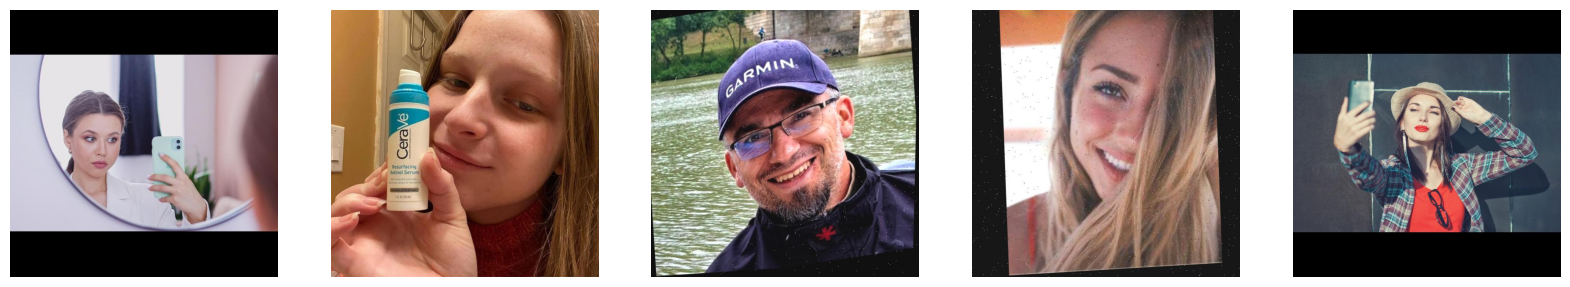

Class :  normal


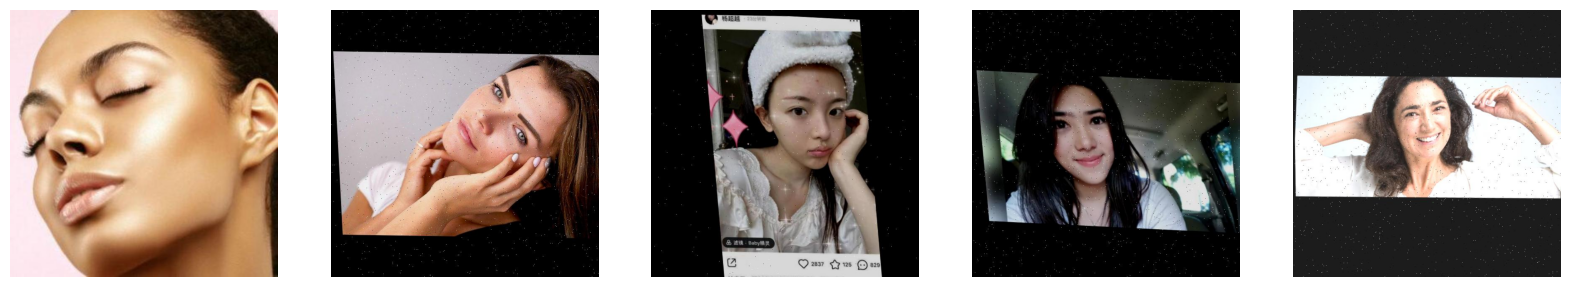

Class :  oily


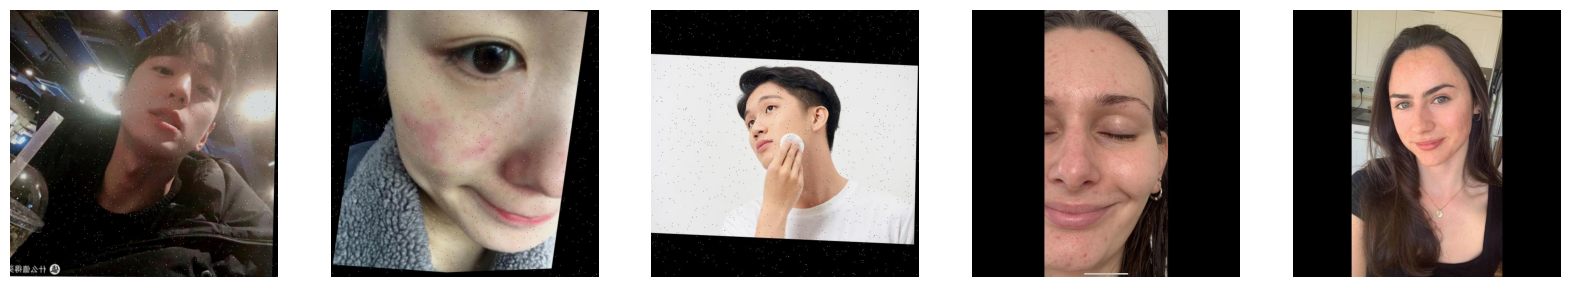

In [13]:
# visualsiasi untuk train_path

plot_images(train_path)

Class :  dry


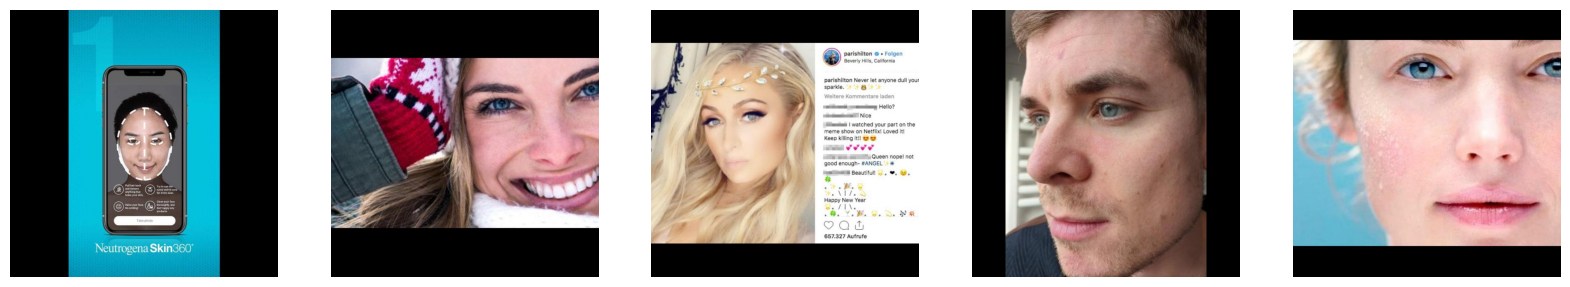

Class :  normal


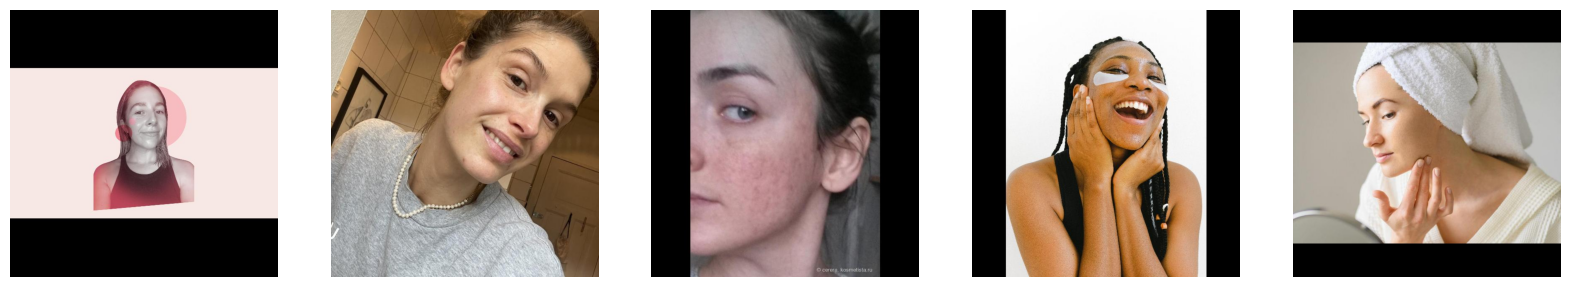

Class :  oily


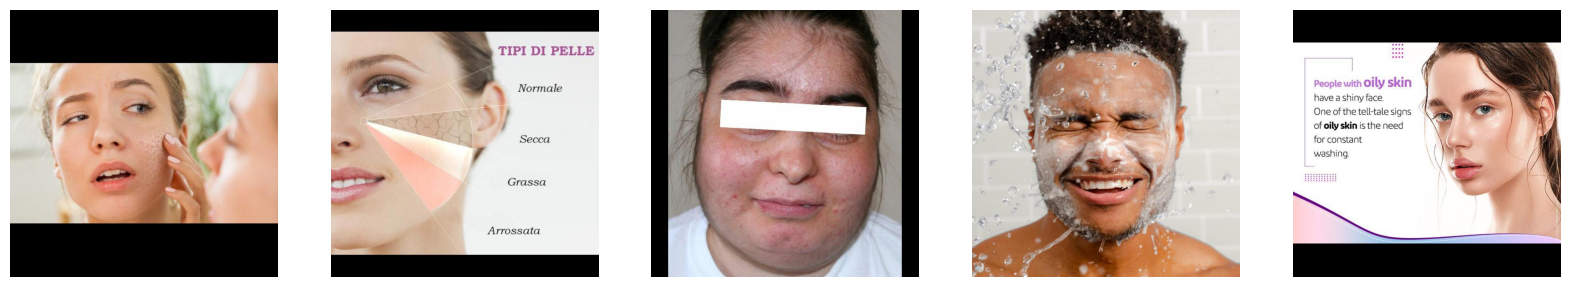

In [14]:
# visualsiasi untuk `test_path`

plot_images(test_path)

Class :  dry


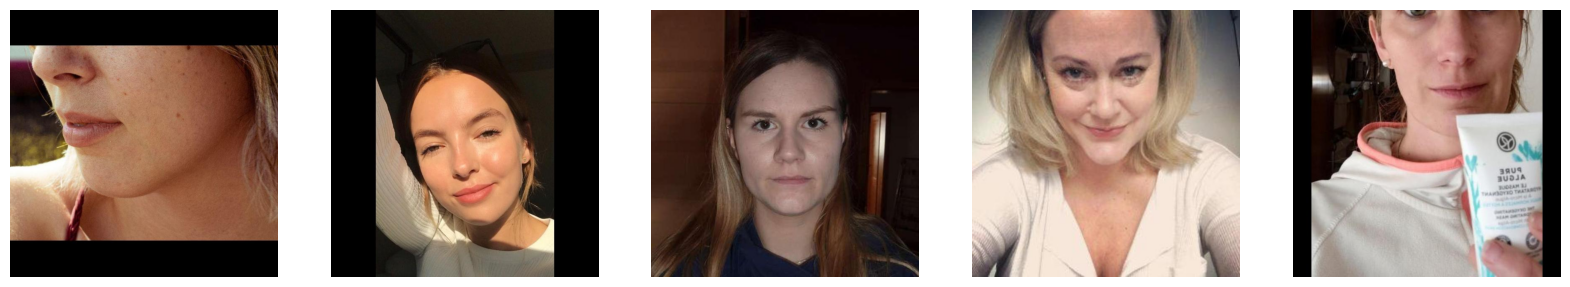

Class :  normal


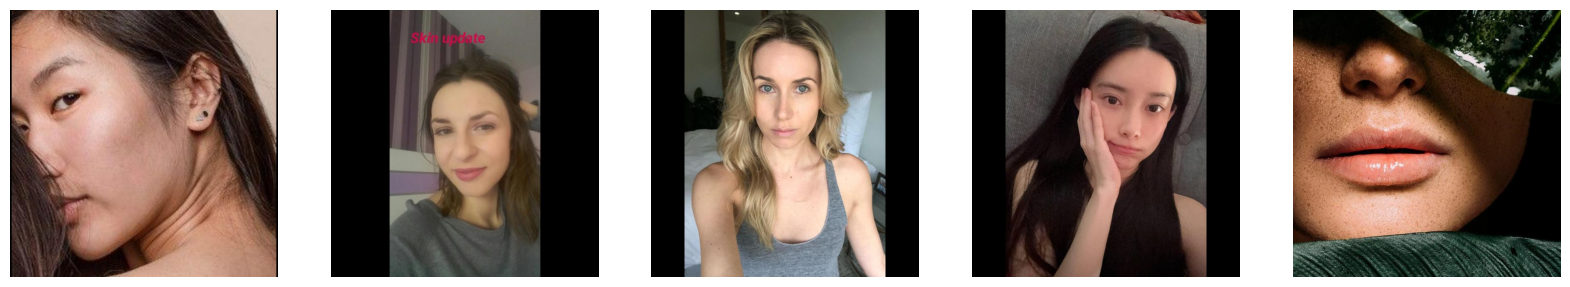

Class :  oily


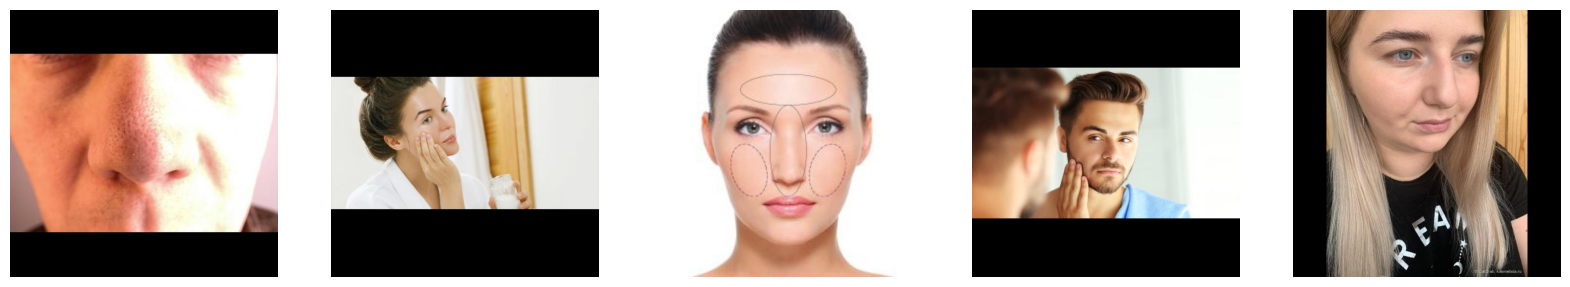

In [15]:
# visualsiasi untuk `val_path`

plot_images(val_path)

# 4. Exploratory Data Analysis (EDA)

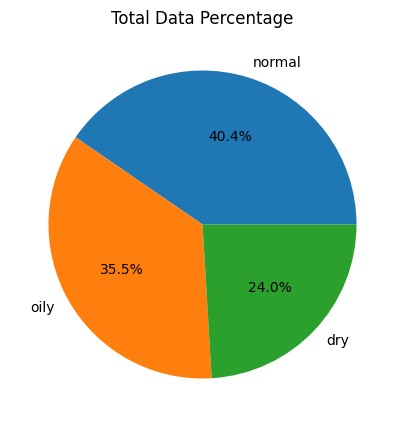

{'normal': 1274, 'oily': 1120, 'dry': 758}


In [16]:
def get_data_counts(path):
    counts = {}
    labels = os.listdir(path)
    for label in labels:
        num_data = len(os.listdir(os.path.join(path, label)))
        counts[label] = num_data
    return counts

# Get data counts for train, test, and validation paths
train_counts = get_data_counts(train_path)
test_counts = get_data_counts(test_path)
val_counts = get_data_counts(val_path)

# Combine train, test, and validation counts
combined_counts = {
    label: train_counts.get(label, 0) + test_counts.get(label, 0) + val_counts.get(label, 0)
    for label in set(train_counts) | set(test_counts) | set(val_counts)
}

# Prepare data for plotting
labels = list(combined_counts.keys())
values = [combined_counts[label] for label in labels]

# Create the pie chart
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(values, labels=labels, autopct='%1.1f%%')

# Add a title
ax.set_title('Total Data Percentage')

plt.show()

# Print the combined counts
print(combined_counts)

In [17]:
# mengecek jumlah data pada train, test, dan val

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

print('Val Path')
check_path(val_path)
print('')

Train Path
Total Data - dry : 652
Total Data - normal : 1104
Total Data - oily : 1000

Test Path
Total Data - dry : 35
Total Data - normal : 59
Total Data - oily : 40

Val Path
Total Data - dry : 71
Total Data - normal : 111
Total Data - oily : 80



- Kategori "normal" memiliki jumlah data yang paling banyak di setiap set data (training, testing, dan validation). Kategori "dry" memiliki jumlah data yang paling sedikit di set training dan testing, tetapi jumlahnya cukup signifikan di set validation.

- Terdapat ketidakseimbangan yang jelas antara jumlah data di setiap kategori, terutama di set training. Kategori "normal" jauh lebih dominan dibandingkan kategori "dry" dan "oily". Ketidakseimbangan ini termasuk kedalam level moderate, yaitu 1 - 20%.

- Jumlah data di set testing dan validation cukup kecil, dan distribusinya cenderung mirip dengan set training, hanya proporsinya saja yang lebih kecil.

# 5. Baseline Model

## 5.1 Model Definition

In [18]:
# Define hyperparameters

img_height= 220
img_width= 220
batch_size= 64

In [19]:
# membuat batch generator untuk train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

val_set = valid_datagen.flow_from_directory(val_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

Found 2756 images belonging to 3 classes.
Found 134 images belonging to 3 classes.
Found 262 images belonging to 3 classes.


Ketiga set (training, testing, dan validation) memiliki distribusi kelas yang konsisten dengan 3 kelas yang sama. Ini memastikan bahwa model memiliki kesempatan untuk belajar dan menguji semua kelas yang relevan. Pada training set dan validation set, data dishuffle agar membantu dalam mengurangi bias yang mungkin disebabkan oleh urutan data. Sementara itu, testing set tidak diacak, untuk menjaga konsistensi selama evaluasi.

In [20]:
# Show labels

train_set.class_indices

{'dry': 0, 'normal': 1, 'oily': 2}

## 5.2 Model Training

In [21]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Create Sequential API model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same',activation='relu',strides=(1, 1), input_shape=(img_height, img_width,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

# Train the model

history = model.fit(train_set, epochs=20, validation_data=val_set, batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

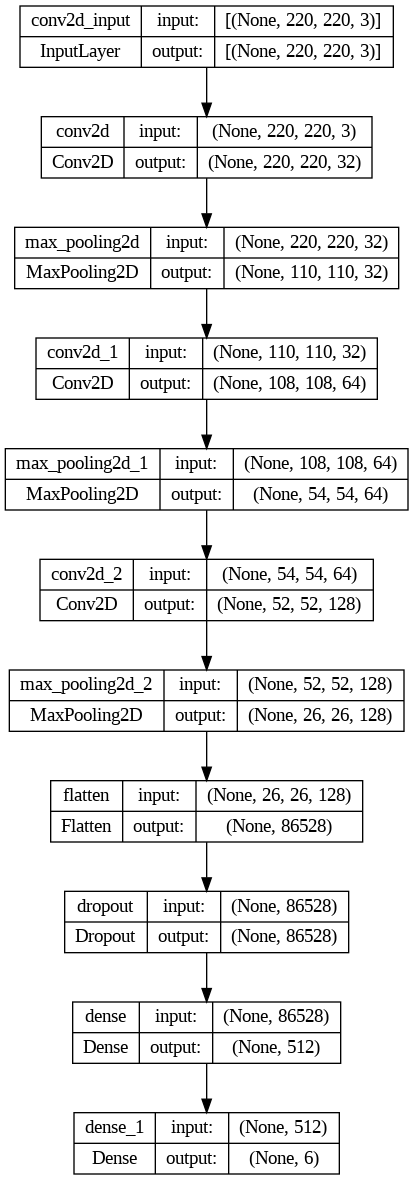

In [22]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

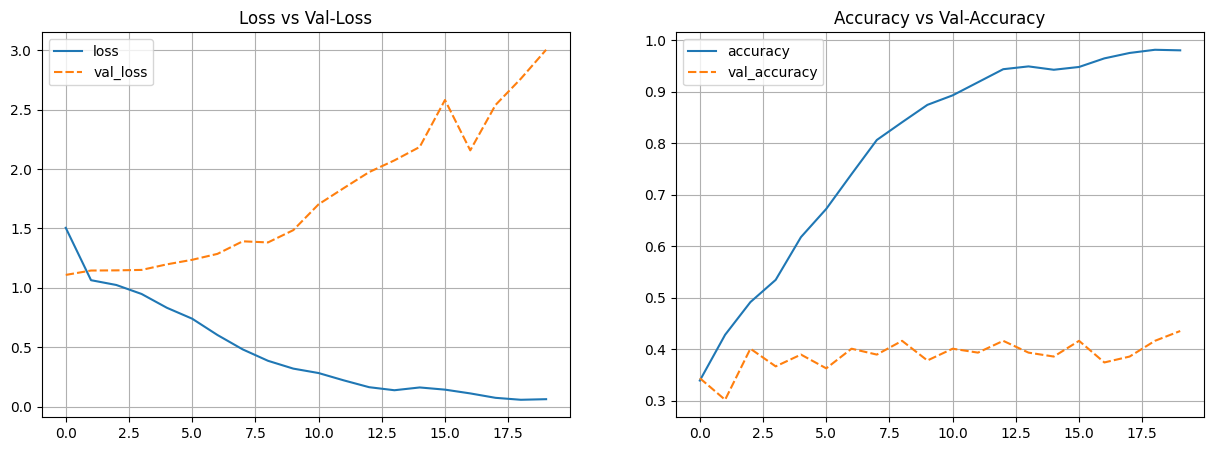

In [23]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

## 5.3 Model Evaluation

In [24]:
predictions = model.predict(test_set)

3/3 [==============================] - 1s 112ms/step


In [25]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model.predict(test_set)

## Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

3/3 [==============================] - 0s 115ms/step
              precision    recall  f1-score   support

         dry       0.27      0.26      0.26        35
      normal       0.44      0.61      0.51        59
        oily       0.60      0.30      0.40        40

    accuracy                           0.43       134
   macro avg       0.44      0.39      0.39       134
weighted avg       0.45      0.43      0.41       134



# 6. Modeling With Data Augmentation

## 6.1 Model Definition

In [26]:
# Define hyperparameters

img_height= 220
img_width= 220
batch_size= 64

In [27]:
# membuat batch generator untuk train-set, val-set, and test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                rotation_range=20,
                                                                zoom_range=0.05,
                                                                width_shift_range=0.05,
                                                                height_shift_range=0.05,
                                                                shear_range=0.05,
                                                                horizontal_flip=True,)

train_set_aug = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)


test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

valid_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

val_set_aug = valid_datagen.flow_from_directory(val_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

Found 2756 images belonging to 3 classes.
Found 134 images belonging to 3 classes.
Found 262 images belonging to 3 classes.


## 6.2 Model Training

In [28]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Create Sequential API model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D

model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(GlobalAveragePooling2D())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(128, activation='relu'))
model_aug.add(Dense(3, activation='softmax'))

# Compile
model_aug.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 27, 27, 128)       0

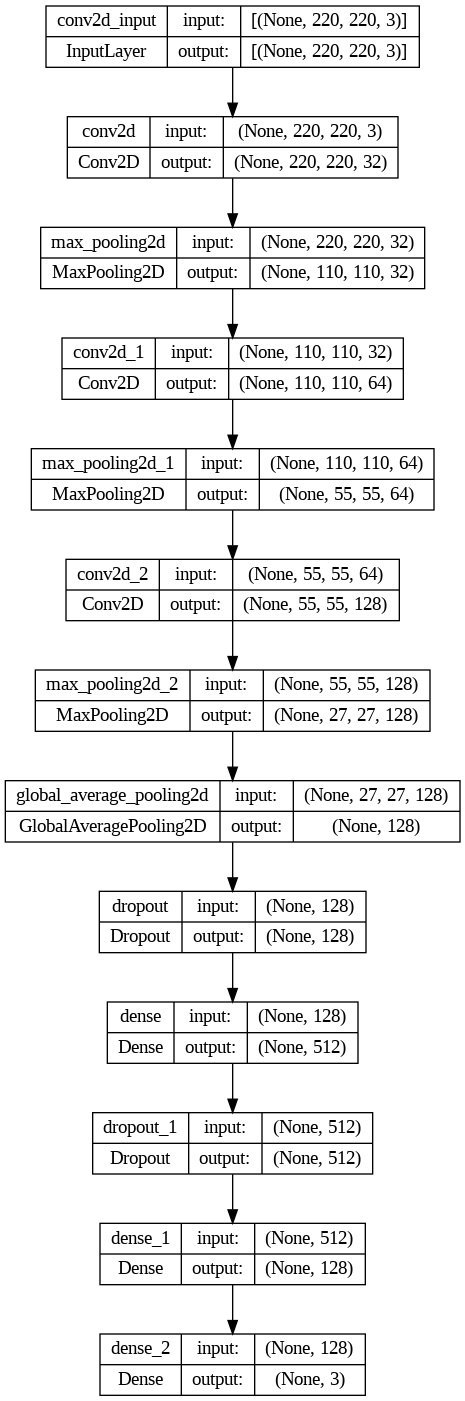

In [29]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

- Model ini memiliki jumlah parameter yang moderat, cukup untuk menangkap pola kompleks dalam data gambar.

- Model menggunakan beberapa lapisan convolutional dengan jumlah filter yang meningkat secara bertahap, untuk membantu dalam extraction.

- Dropout diterapkan di beberapa titik untuk mengurangi kemungkinan overfitting.

- Dengan lapisan output menggunakan softmax, model ini diatur untuk klasifikasi multi-kelas dengan 3 kelas (oily, dry, normal).

- Model menggunakan adam optimizer dan sparse categorical crossentropy sebagai loss function, yang sesuai untuk multi class classification.

In [30]:
# Train the model

%%time
history_aug = model_aug.fit(train_set_aug, epochs=20, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/20
44/44 [==============================] - 21s 340ms/step - loss: 1.0842 - accuracy: 0.3966 - val_loss: 1.0878 - val_accuracy: 0.4237
Epoch 2/20
44/44 [==============================] - 12s 274ms/step - loss: 1.0744 - accuracy: 0.3966 - val_loss: 1.0878 - val_accuracy: 0.4237
Epoch 3/20
44/44 [==============================] - 11s 258ms/step - loss: 1.0745 - accuracy: 0.3955 - val_loss: 1.0885 - val_accuracy: 0.4237
Epoch 4/20
44/44 [==============================] - 12s 265ms/step - loss: 1.0769 - accuracy: 0.3886 - val_loss: 1.0839 - val_accuracy: 0.4237
Epoch 5/20
44/44 [==============================] - 12s 279ms/step - loss: 1.0769 - accuracy: 0.4006 - val_loss: 1.0880 - val_accuracy: 0.4237
Epoch 6/20
44/44 [==============================] - 12s 274ms/step - loss: 1.0739 - accuracy: 0.4013 - val_loss: 1.0861 - val_accuracy: 0.4237
Epoch 7/20
44/44 [==============================] - 12s 268ms/step - loss: 1.0744 - accuracy: 0.3984 - val_loss: 1.0855 - val_accuracy: 0.4237

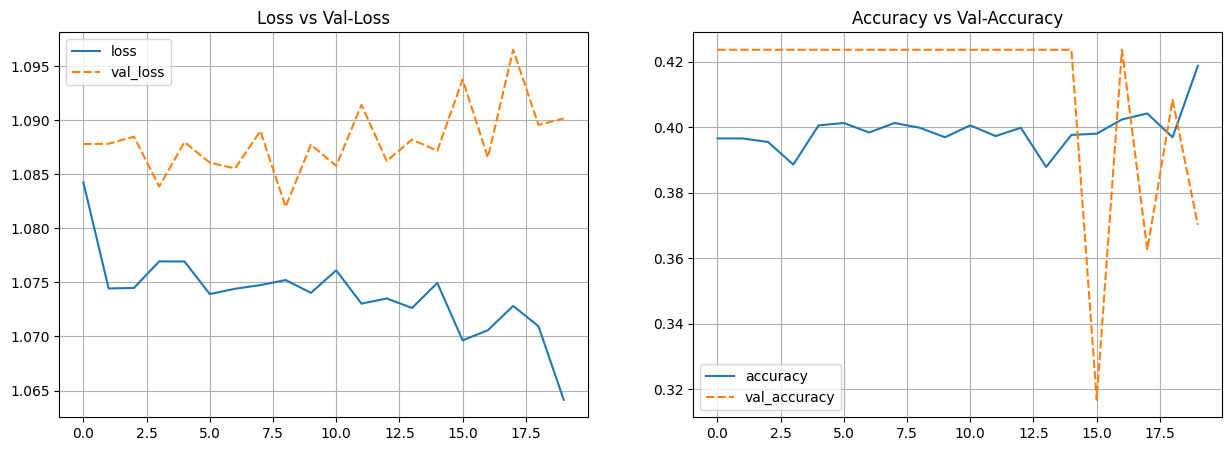

In [31]:
# Plot training results

history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

- Performa model menunjukkan underfit

- Training loss: Mengalami penurunan sedikit dari 1.0816 pada epoch pertama hingga 1.0608 pada epoch terakhir.

- Training accuracy: Mengalami kenaikan dan penurunan, dengan nilai tertinggi mencapai 41.44% pada epoch ke-10 dan nilai terendah sekitar 37.84% pada epoch pertama dan ke-16. Meskipun terdapat penurunan loss secara bertahap, akurasi pada data training menunjukkan kenaikan dan penurunan yang cukup besar dan tidak meningkat secara konsisten

- Validation loss: Relative stabil dengan sedikit fluktuasi, mulai dari 1.0850 pada epoch pertama dan berakhir pada 1.0913 pada epoch terakhir.

- Validation accuracy: Tidak menunjukkan peningkatan signifikan, dengan nilai tertinggi mencapai 43.13% pada epoch ke-13 dan nilai terendah sekitar 32.44% pada epoch ke-8 dan ke-10.

## 6.3 Model Evaluation

In [32]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model_aug.predict_generator(test_set)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

              precision    recall  f1-score   support

         dry       0.00      0.00      0.00        35
      normal       0.44      0.42      0.43        59
        oily       0.34      0.65      0.44        40

    accuracy                           0.38       134
   macro avg       0.26      0.36      0.29       134
weighted avg       0.29      0.38      0.32       134



- Model tidak mampu mengidentifikasi class dry sama sekali, mungkin ada masalah dalam dataset atau data nya tidak cukup representatif untuk kelas ini.

- Performa untuk kelas normal dan oily lebih baik dibandingkan dengan dry, tetapi masih menunjukkan hasil yang tidak memuaskan.
Akurasi keseluruhan model cukup rendah, yaitu 38%, menunjukkan bahwa model perlu diperbaiki dan masih punya banyak ruang untuk dikembangkan.

# 7. Modeling With Transfer Learning

## 7.1 Model Definition

In [33]:
# Define hyperparameters sesuai dengan pretrained model

img_height= 224
img_width= 224
batch_size= 64

In [34]:
# Download pretrained model

pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))
pretrained_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [35]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_set_tl = train_datagen_tl.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)


test_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_set_tl = test_datagen_tl.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

valid_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

val_set_tl = valid_datagen_tl.flow_from_directory(val_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

Found 2756 images belonging to 3 classes.
Found 134 images belonging to 3 classes.
Found 262 images belonging to 3 classes.


## 7.2 Model Training

In [36]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Create Sequential API model

model_tl = Sequential()
model_tl.add(pretrained_model)
model_tl.add(Flatten())
model_tl.add(Dense(512, activation='relu'))
model_tl.add(Dense(128, activation='relu'))
model_tl.add(Dense(3, activation='softmax'))

# Compile
model_tl.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 27626307 (105.39 MB)
Trainable params: 12911619 (49.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


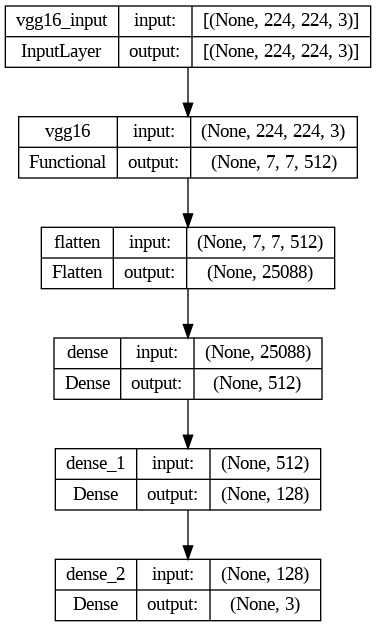

In [37]:
# Plot layers

tf.keras.utils.plot_model(model_tl, show_shapes=True)

In [38]:
# Train the model

%%time
history_tl = model_tl.fit(train_set_tl, epochs=20, validation_data=val_set_tl, batch_size=batch_size)

Epoch 1/20
44/44 [==============================] - 34s 466ms/step - loss: 8.8924 - accuracy: 0.4909 - val_loss: 4.6523 - val_accuracy: 0.3244
Epoch 2/20
44/44 [==============================] - 17s 380ms/step - loss: 1.0365 - accuracy: 0.8345 - val_loss: 5.0848 - val_accuracy: 0.3893
Epoch 3/20
44/44 [==============================] - 16s 351ms/step - loss: 0.3966 - accuracy: 0.9253 - val_loss: 4.8850 - val_accuracy: 0.3740
Epoch 4/20
44/44 [==============================] - 15s 348ms/step - loss: 0.3014 - accuracy: 0.9401 - val_loss: 5.1311 - val_accuracy: 0.4008
Epoch 5/20
44/44 [==============================] - 16s 350ms/step - loss: 0.1613 - accuracy: 0.9681 - val_loss: 5.5390 - val_accuracy: 0.3931
Epoch 6/20
44/44 [==============================] - 25s 567ms/step - loss: 0.0958 - accuracy: 0.9848 - val_loss: 6.0596 - val_accuracy: 0.3893
Epoch 7/20
44/44 [==============================] - 18s 413ms/step - loss: 0.0735 - accuracy: 0.9909 - val_loss: 5.5980 - val_accuracy: 0.3893

- Model ini menggabungkan struktur VGG16 dengan beberapa lapisan dense tambahan untuk klasifikasi akhir.

- Model menggunakan loss function sparse categorical crossentropy, optimizer adam, dan metrik accuracy. Semuanya disamakan seperti saat modeling menggunakan data augmentasi, agar bisa dibandingkan hasilnya.

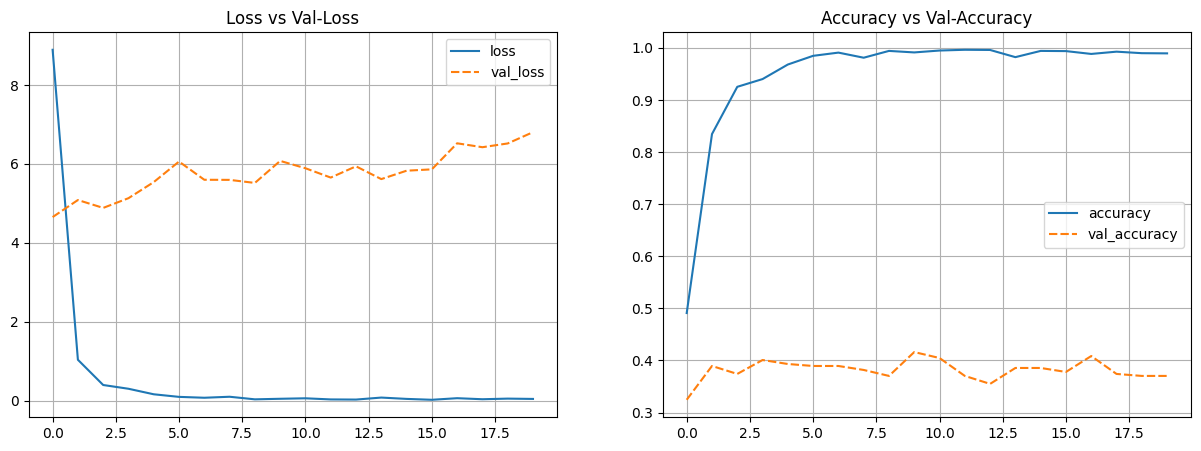

In [39]:
# Plot training results

history_tl_df = pd.DataFrame(history_tl.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_tl_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

- Performa model menunjukkan overfit yang signifikan. Akurasi pada training meningkat secara drastis sementara akurasi pada validation mengalami penurunan seiring berjalannya waktu. Nilai loss dari training set dan validation set mengindikasikan bahwa model mungkin terlalu menyesuaikan diri dengan data training dan tidak digeneralisasi dengan baik pada data validation.

- Training loss: Pada epoch pertama, loss sangat tinggi, yaitu 14.12 tetapi berkurang secara signifikan sepanjang epoch menjadi 0.0445 pada epoch ke-20.

- Training accuracy: Akurasi mulai dari 49.06% pada epoch ke-1 dan meningkat hingga 99.42% di epoch ke-20 pada data training set.

- Validation loss: Mulai dari 4.18 pada epoch pertama dan menunjukkan kenaikan dan penurunan, akhirnya menjadi 8.45 pada epoch ke-20.

- Validation accuracy: Akurasi validation mulai dari 36.64% pada epoch ke-1 dan cenderung stagnan atau menurun sedikit, akhirnya menjadi 36.64% pada epoch ke-20, yang mana nilai tersebut sama dengan epoch pertama.

## 7.3 Model Evaluation

In [40]:
# Check the performance of test-set

## Get the probability
y_pred_prob_tl = model_tl.predict_generator(test_set_tl)

## Get class with maximum probability
y_pred_class_tl = np.argmax(y_pred_prob_tl, axis=-1)

## Display Classification Report
print(classification_report(test_set_tl.classes, y_pred_class_tl, target_names=np.array(list(train_set_tl.class_indices.keys()))))

              precision    recall  f1-score   support

         dry       0.32      0.43      0.37        35
      normal       0.53      0.36      0.42        59
        oily       0.38      0.45      0.41        40

    accuracy                           0.40       134
   macro avg       0.41      0.41      0.40       134
weighted avg       0.43      0.40      0.41       134



- Kelas dry memiliki kinerja yang kurang baik dibandingkan dengan kelas lainnya. Model cukup lemah dalam mendeteksi dan mengklasifikasikan data untuk kelas ini.

- Kelas normal menunjukkan performa yang paling baik dibandingkan dengan kelas lainnya. Ini adalah kelas yang paling mudah untuk diklasifikasikan dengan benar oleh model.

- Kelas oilyini memiliki skor yang hampir mirip dengan kelas dry. Kelas oily juga memiliki kinerja yang kurang memuaskan.

- Model transfer learning menunjukkan performa yang lebih baik pada tiap kelasnya dibandingkan dengan modeling menggunakan data augmentation. Hal ini dapat dilihat juga dari skor akurasinya, yang menunjukkan bahwa transfer learning memberikan hasil yang lebih baik secara keseluruhan.

# 8. Best Model with Different Tuning

Dikarenakan hasil evaluasi yang terbaik adalah dengan menggunakan transfer learning, maka model ini akan dilakukan tuning lebih lanjut untuk meningkatkan nilai evaluasinya.

## 8.1 Model Training

In [52]:
# Create Sequential API model

model_tl_do = Sequential()
model_tl_do.add(pretrained_model)
model_tl_do.add(Flatten())
model_tl_do.add(Dense(512, activation='relu'))
model_tl_do.add(Dense(128, activation='relu'))
model_tl_do.add(Dense(3, activation='softmax'))

# Compile
model_tl_do.compile(loss='sparse_categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])
model_tl_do.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 3)                 387       
                                                                 
Total params: 27626307 (105.39 MB)
Trainable params: 12911619 (49.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


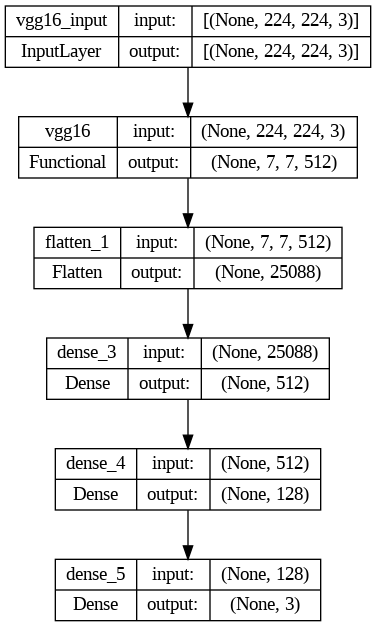

In [42]:
# Plot layers

tf.keras.utils.plot_model(model_tl_do, show_shapes=True)

In [43]:
# Train the model

%%time
history_tl_do = model_tl_do.fit(train_set_tl, epochs=20, validation_data=val_set_tl, batch_size=batch_size)

Epoch 1/20
44/44 [==============================] - 21s 430ms/step - loss: 7.3642 - accuracy: 0.4706 - val_loss: 2.3814 - val_accuracy: 0.3817
Epoch 2/20
44/44 [==============================] - 15s 337ms/step - loss: 0.4060 - accuracy: 0.8708 - val_loss: 2.5183 - val_accuracy: 0.3397
Epoch 3/20
44/44 [==============================] - 16s 356ms/step - loss: 0.0926 - accuracy: 0.9746 - val_loss: 2.4601 - val_accuracy: 0.3740
Epoch 4/20
44/44 [==============================] - 16s 350ms/step - loss: 0.0437 - accuracy: 0.9938 - val_loss: 2.4832 - val_accuracy: 0.3626
Epoch 5/20
44/44 [==============================] - 15s 349ms/step - loss: 0.0230 - accuracy: 0.9964 - val_loss: 2.4894 - val_accuracy: 0.3626
Epoch 6/20
44/44 [==============================] - 16s 355ms/step - loss: 0.0159 - accuracy: 0.9967 - val_loss: 2.5487 - val_accuracy: 0.3550
Epoch 7/20
44/44 [==============================] - 16s 354ms/step - loss: 0.0174 - accuracy: 0.9960 - val_loss: 2.6700 - val_accuracy: 0.3550

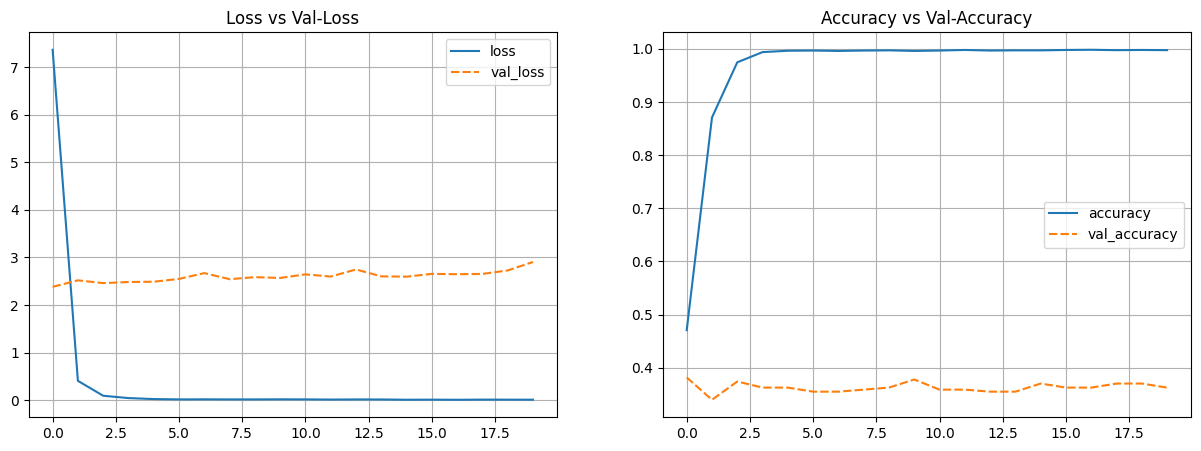

In [44]:
# Plot training results

history_tl_do_df = pd.DataFrame(history_tl_do.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_tl_do_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl_do_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

- Sudah dilakukan berbagai macam tuning pada model ini, yaitu dropout, batch normalization, mencoba beberapa kombinasi layer, mencoba activation function yang lain seperti elu dan leaky_relu, tetapi model mengalami penurunan yang sangat signifikan dibandingkan sebelum dituning, kombinasi terbaik yang ditemukan adalah hanya mengganti optimizer dari adam menjadi adamax.

- Transfer learning yang sudah dituning memiliki performa yang lebih konsisten pada data validation set meskipun akurasinya tidak setinggi model yang sebelum dituning. Model ini lebih baik dalam hal generalisasi dan overfittingnya tidak separah seperti model yang belum dituning.

- Terlihat adanya indikasi overfitting pada model. Akurasi dan loss pada training set menunjukkan performa yang sangat baik, sementara akurasi dan loss pada data validation set tidak menunjukkan perbaikan yang konsisten.

- Training loss: Mengalami penurunan yang dari 6.9600 pada epoch pertama menjadi 0.0109 pada epoch terakhir. Ini menandakan bahwa model sangat baik dalam mengurangi loss pada training set.

- Training accuracy: Model menunjukkan peningkatan akurasi yang sangat tinggi, mulai dari 49.09% pada epoch pertama dan meningkat menjadi 99.75% pada epoch terakhir. Ini menunjukkan bahwa model belajar dengan baik pada training set.

- Validation loss: Menunjukkan fluktuasi dan tidak menunjukkan penurunan yang konsisten, dengan nilai 2.8545 pada epoch pertama hingga 3.0374 pada epoch terakhir. Ini mengindikasikan bahwa model mungkin mengalami overfitting.

- Validation accuracy: Meskipun akurasi training meningkat, akurasi validation tidak menunjukkan peningkatan secara konsisten. Akurasi validation set dimulai dari 36.26% dan mencapai puncaknya di 41.22% pada epoch ke-19, tetapi kemudian menurun kembali ke 37.79% pada epoch terakhir.



## 8.2 Model Evaluation

In [45]:
# Check the performance of test-set

# Get the probability
y_pred_prob_tl_do = model_tl_do.predict_generator(test_set_tl)

# Get class with maximum probability
y_pred_class_tl_do = np.argmax(y_pred_prob_tl_do, axis=-1)

# Display Classification Report
print(classification_report(test_set_tl.classes, y_pred_class_tl_do, target_names=np.array(list(train_set_tl.class_indices.keys()))))

              precision    recall  f1-score   support

         dry       0.29      0.26      0.27        35
      normal       0.52      0.66      0.58        59
        oily       0.50      0.35      0.41        40

    accuracy                           0.46       134
   macro avg       0.44      0.42      0.42       134
weighted avg       0.45      0.46      0.45       134



Performa model ini masih kurang memuaskan, model menunjukkan akurasi sebesar 46%. Angka ini relatif rendah, yang mengindikasikan bahwa model tidak bekerja dengan baik dan tidak konsisten di berbagai kelas. Model belum optimal dalam membedakan antara kelas-kelas yang ada.

# 9. Model Saving

In [53]:
model_path = '/content/drive/MyDrive/GC7/model_tl_do.h5'
model_tl_do.save(model_path)

In [47]:
model_tl_do.save('model_tl_do.h5')

# 10. Kesimpulan

- Dilakukan pembuatan model untuk memprediksi jenis kulit pada wajah, apakah oily, normal, atau dry.

- Model pertama adalah baseline model, yang tidak dilakukan apapun. Model kedua adalah model yang menggunakan data augmentation, tetapi ke dua model ini hasilnya kurang memuaskan.

- Model ketiga adalah transfer learning menggunakkan pre-trained model VGG16. Untuk multi-class image classification, ada 4 top pre-trained model, yaitu VGG-16, Inception, ResNet50, and EfficientNet (Source: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/). Sudah dilakukan training dan evaluation pada ke 4 pre-trained model tersebut, dan yang terbaik adalah VGG-16.

- Dari hasil evaluasi ke-3 model tersebut, model yang terbaik adalah model yang menggunakan transfer learning. Akan dilakukan tuning untuk meningkatkan nilai evaluasinya.

- Setelah dilakukan berbagai macam tuning, kombinasi terbaik yang ditemukan adalah hanya mengganti optimizer dari adam menjadi adamax.

# 11. Rekomendasi

## 11.1 Rekomendasi Model

Dikarenakan waktu yang tidak mencukupi, berikut adalah beberapa rekomendasi untuk improve model yang belum sempat untuk dilakukan:

- Memastikan distribusi kelas dalam data training dan test tidak terlalu timpang. Gunakan teknik seperti oversampling kelas minoritas atau undersampling kelas mayoritas.

- Lebih mencoba berbagai kombinasi pada arsitektur model atau mencoba algoritma lain.

- Mengumpulkan data tambahan

## 11.2 Rekomendasi Bisnis

Dikarenakan hasil evaluasi yang kurang memuaskan, saya tidak merekomendasikan untuk menggunakan model ini untuk keperluan bisnis. Tetapi, apabila model telah dilakukan improvment dan hasilnya menjadi jauh lebih baik, berikut adalah beberapa rekomendasi:

- Menawarkan layanan konsultasi kulit virtual di mana profesional kecantikan menggunakan model untuk memberikan analisis dan rekomendasi produk kepada klien mereka.

- Gunakan model untuk melakukan analisis awal jenis kulit pasien sebagai bagian dari konsultasi. Implementasikan model dalam perangkat atau aplikasi yang digunakan oleh klinik kecantikan untuk analisis kulit. Ini dapat mempercepat proses diagnosis dan memberikan dasar yang kuat untuk rekomendasi perawatan.

- Improve model agar tidak hanya menganalisis jenis kulit tetapi juga memberikan rekomendasi rutin perawatan kulit dan produk berdasarkan hasil analisis.

-  Platform B2B
API untuk E-Commerce: Kembangkan API yang dapat digunakan oleh platform e-commerce untuk memberikan rekomendasi produk berdasarkan analisis jenis kulit.